<a href="https://colab.research.google.com/github/Jaesu26/korean-aspect-based-sentiment-analysis/blob/main/2022-10-26-%EC%86%8D%EC%84%B1%EA%B8%B0%EB%B0%98-%EA%B0%90%EC%84%B1-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 국립국어원 인공지능 언어능력평가

In [1]:
!nvidia-smi

Wed Oct 26 12:26:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
!pip install soynlp
!pip install emoji
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`-` 런타임 재시작

## 데이터 불러오기

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import json
import os
import re
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import f1_score

from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
from numpy.typing import NDArray

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [5]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd  '/content/drive/MyDrive/Colab Notebooks/속성기반-감성-분류'

/content/drive/MyDrive/Colab Notebooks/속성기반-감성-분류


- 데이터 불러오기

In [7]:
JsonType = Dict[str, Any]

In [8]:
train_path = './data/nikluge-sa-2022-train.jsonl'
valid_path = './data/nikluge-sa-2022-dev.jsonl'
test_path = './data/nikluge-sa-2022-test.jsonl'
submission_path = './data/nikluge-sa-2022-submission.jsonl'

In [9]:
def load_jsonl(file_path: str, encoding: str = 'utf-8') -> List[JsonType]:
    """jsonl 파일을 읽어서 list에 저장"""
    json_list = []
    with open(file_path, encoding=encoding) as f:
        for line in f.readlines():
            json_list.append(json.loads(line))
    return json_list

In [10]:
def write_jsonl(jsonl: List[JsonType], file_path: str) -> None:
    """jsonl 파일을 write"""
    with open(file_path, mode='w', encoding='utf-8') as f: 
        for j in jsonl: 
            json.dump(j, f, ensure_ascii=False)
            f.write('\n')

In [11]:
def jsonl2df(jsonl: List[JsonType]) -> pd.DataFrame:
    """
    jsonl을 dataframe으로 변경한 후 반환
    For entity property classification
    """
    ids = []
    texts = []
    entity_properties = []
    sentiments = []
    
    for json in jsonl:
        annotations = json['annotation']
        ids.append(json['id'].split('-')[-1])
        texts.append(json['sentence_form'])
        entity_properties.append([annotation[0] for annotation in annotations])
        sentiments.append([annotation[2] for annotation in annotations])
        
    df = pd.DataFrame({'id':ids,
                        'text':texts,
                        'entity_property':entity_properties,
                        'sentiment':sentiments})
    return df

In [12]:
def to_tidy(df: pd.DataFrame, exist_sentiment: bool = True) -> pd.DataFrame:
    """
    entity_property 변수가 한 행에 하나의 개체 속성만 가지도록 변환
    For visualization and sentiment classification
    """
    list_df = df.to_numpy().tolist()
    ids = []
    texts = []
    entity_properties = []
    sentiments = []

    for id, text, entity_property, sentiment in list_df:
        if not exist_sentiment:
            sentiment = [[] for _ in range(len(entity_property))]

        for e, s in zip(entity_property, sentiment):
            ids.append(id)
            texts.append(text)
            entity_properties.append(e)
            sentiments.append(s) 

    df = pd.DataFrame({'id':ids,
                       'text':texts,
                       'entity_property':entity_properties,
                       'sentiment':sentiments})
    return df

In [13]:
def to_untidy(df: pd.DataFrame) -> pd.DataFrame:
    ids = []
    texts = []
    entity_properties = [] 
    sentiments = [] 

    for id in sorted(df['id'].unique()):
        tmp = df.query('id == @id')
        ids.append(id)
        texts.append(tmp['text'].values[0])
        entity_properties.append(tmp['entity_property'].tolist())
        sentiments.append(tmp['sentiment'].tolist())

    df = pd.DataFrame({'id':ids,
                       'text':texts,
                       'entity_property':entity_properties,
                       'sentiment':sentiments})
    return df

In [14]:
df = jsonl2df(load_jsonl(train_path))
tidy_df = to_tidy(jsonl2df(load_jsonl(train_path)))

valid = jsonl2df(load_jsonl(valid_path))
tidy_valid = to_tidy(jsonl2df(load_jsonl(valid_path)))

test = jsonl2df(load_jsonl(test_path))

In [15]:
tidy_df.head() 

,id,text,entity_property,sentiment
0,00001,둘쨋날은 미친듯이 밟아봤더니 기어가 헛돌면서 틱틱 소리가 나서 경악.,본품#품질,negative
1,00002,"이거 뭐 삐꾸를 준 거 아냐 불안하고, 거금 투자한 게 왜 이래.. 싶어서 정이 확...",본품#품질,negative
2,00003,간사하게도 그 이후에는 라이딩이 아주 즐거워져서 만족스럽게 탔다.,제품 전체#일반,positive
3,00004,샥이 없는 모델이라 일반 도로에서 타면 노면의 진동 때문에 손목이 덜덜덜 떨리고 이...,제품 전체#일반,neutral
4,00005,안장도 딱딱해서 엉덩이가 아팠는데 무시하고 타고 있다.,본품#일반,negative


- 하이퍼파라미터 (개체 속성과 감성)

In [17]:
MODEL_PATHS = {'electra':'kykim/electra-kor-base', 
               'funnel':'kykim/funnel-kor-base',
               'bert':'kykim/bert-kor-base',}

MODEL_NAME = 'bert'
MODEL_DEFAULT_WEIGHT_PATHS = {'ACD':f'acd_{MODEL_NAME}_default_weight.pt', 
                              'ASC':f'asc_{MODEL_NAME}_default_weight.pt'} 

SAVE_PATHS = {'ACD':'./acd_weight',
              'ASC':'./asc_weight'}

NUM_CLASSES = {'ACD':len(tidy_df['entity_property'].unique()),   
               'ASC':len(tidy_df['sentiment'].unique())}
NUM_FOLDS = 5
NUM_EPOCHS = {'ACD':30, 'ASC':20}
MAX_LEN = 45
BATCH_SIZE = 64
LEARNING_RATE = {'ACD':5e-5, 'ASC':1e-4}
LABEL_SMOOTHING = 0.05  
SEEDS = [2022, 2023, 2024, 2025, 2026]  ## seed ensemble
NUM_FOLDS = len(SEEDS) 

- 가중치 저장폴더

In [ ]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [ ]:
create_folder(SAVE_PATHS['ACD'])
create_folder(SAVE_PATHS['ASC'])

## 시각화

### 라벨

In [ ]:
plt.rc('font', family='NanumBarunGothic')

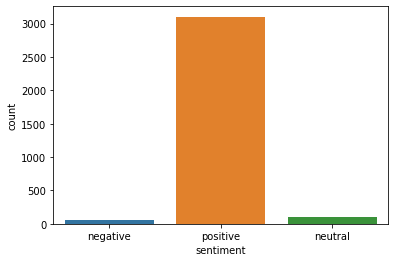

In [ ]:
sns.countplot(tidy_df['sentiment'])

`-` 라벨 불균형이 매우 심하다

`-` 하지만 평가 산식은 단순히 라벨을 맞췄냐 못맞췄냐로만 판단한다

`-` 즉, 단순 `f1 score`이므로 적은 클래스의 카테고리는 내다 버려도 좋은 점수를 얻을 수 있다

`-` 속성 기반 감성 분류인데 감성 대부분이 긍정이므로 사실상 속성 분류 테스크와 같다

`-` 그런데 train과 test의 분포가 다르다면?......

`-` 무작위로 샘플링했다면 둘의 분포가 비슷할 것이다

### 개체 속성

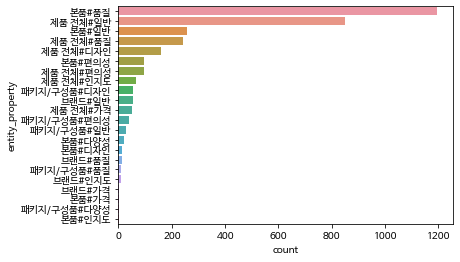

In [ ]:
sns.countplot(y=tidy_df['entity_property'], order=tidy_df['entity_property'].value_counts().index)

`-` 개체 속성도 불균형이 심하다

`-` 하지만 단순히 맞췄냐 못맞췄냐로 판단하므로 적은 클래스는 내다 버려도 좋은 점수를 얻을 수 있다

In [ ]:
tidy_df['entity_property'].value_counts().to_dict()

{'본품#품질': 1196,
 '제품 전체#일반': 848,
 '본품#일반': 256,
 '제품 전체#품질': 242,
 '제품 전체#디자인': 158,
 '본품#편의성': 95,
 '제품 전체#편의성': 94,
 '제품 전체#인지도': 66,
 '패키지/구성품#디자인': 54,
 '브랜드#일반': 53,
 '제품 전체#가격': 49,
 '패키지/구성품#편의성': 38,
 '패키지/구성품#일반': 30,
 '본품#다양성': 21,
 '본품#디자인': 15,
 '브랜드#품질': 13,
 '패키지/구성품#품질': 11,
 '브랜드#인지도': 9,
 '브랜드#가격': 3,
 '본품#가격': 2,
 '패키지/구성품#다양성': 1,
 '본품#인지도': 1}

### 텍스트

In [ ]:
df['text'].str.len().describe()

count    3001.00000
mean       33.91103
std        20.15056
min         1.00000
25%        19.00000
50%        30.00000
75%        44.00000
max       161.00000
Name: text, dtype: float64

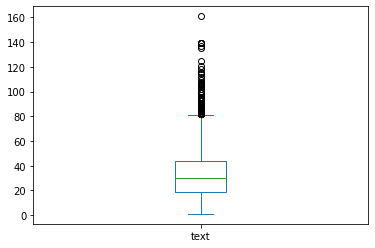

In [ ]:
df['text'].str.len().plot.box()

In [ ]:
def check_word_counts(word: str, texts: Sequence[str], labels: NDArray[np.str_]) -> Dict[str, int]:
    count_dict = {}
    for idx, text in enumerate(texts):
        text = text.lower()
        label = labels[idx]
        if word in text:  ## text 대신 text.split()을 사용하면 더 타이트하게 검출
            if label not in count_dict:
                count_dict[label] = 1
            else:
                count_dict[label] += 1

    all_counts = sum([np.sum(labels == key) for key in list(count_dict.keys())])
    count_dict.update({'합계':sum(count_dict.values())})
    count_list = list(count_dict.items())
    count_list = list(map(list, count_list))

    for item in count_list:
        if item[0] == '합계':
            item.append(all_counts)
        else:
            item.append(np.sum(labels == item[0]))

    count_list = sorted(count_list, key=lambda item: (-item[1], -item[2]))
    return count_list

In [ ]:
check_word_counts('가성비', tidy_df['text'].values, tidy_df['entity_property'].values)

[['합계', 22, 1558],
 ['제품 전체#가격', 13, 49],
 ['본품#일반', 3, 256],
 ['제품 전체#품질', 2, 242],
 ['제품 전체#일반', 1, 848],
 ['제품 전체#디자인', 1, 158],
 ['브랜드#가격', 1, 3],
 ['본품#가격', 1, 2]]

### 텍스트 길이와 토큰 길이

In [ ]:
import torch
from transformers import AutoTokenizer

In [18]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

In [19]:
def clean_text(text: str) -> str:
    text = pattern.sub(' ', text)
    text = emoji.replace_emoji(text, replace='') ## emoji 삭제
    text = url_pattern.sub('', text)  ## url 삭제
    text = text.strip()
    text = repeat_normalize(text, num_repeats=2)
    return text

In [20]:
df['text'] = df['text'].apply(clean_text)
tidy_df['text'] = tidy_df['text'].apply(clean_text)

valid['text'] = valid['text'].apply(clean_text)
tidy_valid['text'] = tidy_valid['text'].apply(clean_text)

test['text'] = test['text'].apply(clean_text)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS[MODEL_NAME])  

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

- 텍스트 길이

In [ ]:
train_texts = df['text'].values

In [ ]:
texts_len = list(map(len, train_texts))

25%:  19.0
50%:  30.0
75%:  43.0
85%:  53.0
90%:  60.0
95%:  72.0
99%:  98.0


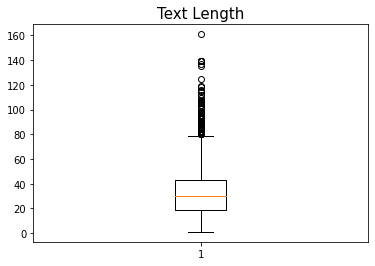

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('90%: ', np.quantile(texts_len, q=0.9))
print('95%: ', np.quantile(texts_len, q=0.95))
print('99%: ', np.quantile(texts_len, q=0.99))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=100,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/3001 [00:00<?, ?it/s]

25%:  10.0
50%:  14.0
75%:  20.0
85%:  23.0
90%:  26.0
95%:  31.0
99%:  42.0


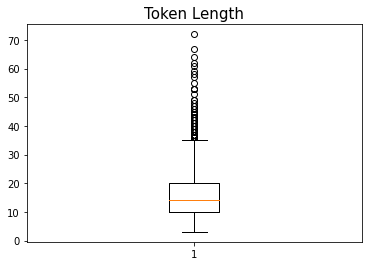

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('90%: ', np.quantile(tokens_len, q=0.9))
print('95%: ', np.quantile(tokens_len, q=0.95))
print('99%: ', np.quantile(tokens_len, q=0.99))
plt.title('Token Length', fontsize=15)
plt.show()

- 산점도

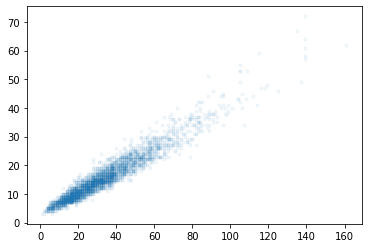

In [ ]:
plt.plot(texts_len, tokens_len, '.', alpha=0.05)

`-` $\text{토큰 길이} \times 2 \approx \text{텍스트 길이}$

## 모델 학습 방법

`-` muti class와 muti label의 차이: https://medium.com/analytics-vidhya/multi-label-classification-a9643d221954

`-` 두개의 task를 한 번에 진행할 필요는 없다 (난이도도 다르니 모델 학습 속도도 다름)

`-` 개체 속성 분류: muti label classification with single class

`-` 감성 분류: muti class classification

`-` 개체 속성 분류 train, validate ---> 감성 분류 train, validate ---> ABSA validate

`-` 개체 속성은 존재하면 1, 아니면 0으로 라벨링 ---> BCEWithlogitsloss ---> 1인 개체 속성에 대해서만 각각 감성분류

`-` 감성 분류에서는 text_pair 인자에 개체 속성을 넘겨줌 ---> CrossEntropy

`-` 개체 속성별로 긍정 데이터 개수의 균형이 맞지 않는다  

`-` 예컨대 `본품#인지도`는 3001개의 텍스트 중에서 오직 1번만 나타난다 (긍정 데이터의 개수가 1이다)

`-` 반면에 `본품#품질`의 경우 긍정 데이터가 1196개의 텍스트에 존재한다

`-` 즉, 3001개의 텍스트를 학습시키는데 `본품#인지도`는 부정(0)인 경우만 과하게 학습하고 `본품#품질`는 다른 개체 속성에 비해 긍정인 경우를 과하게 학습한다

`-` 클래스별로 가중치를 주어 클래스별로 균형있게 학습되도록 하자

`-` 또한 클래스 각각의 라벨별로 가중치를 주어 클래스별로 긍정, 부정 데이터가 균형있게 학습되도록 하자 

`-` 미니배치 단위로 학습하므로 `pos_weight` 만으로는 클래스와 라벨별로 균형있게 학습할 수 없다

`-` `본품#인지도`의 경우 1개의 긍정 라벨의 매우 큰 가중치를 주더라도 하나의 미니배치에서만 영향력을 행사하고 그 뒤로는 나머지 클래스에 의해 학습 방향이 조절된다

`-` 긍정 라벨의 개수가 30보다 작은 개체 속성에 경우 데이터가 너무 적다고 판단해 `pos_weight`를 1로 부여했다

## 모델 학습 준비

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


In [23]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [24]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 전처리

In [25]:
only_valid_entity_columns = list(set(tidy_valid['entity_property'].unique()) - set(tidy_df['entity_property'].unique()))
only_valid_entity_ids = tidy_valid.query('entity_property == @only_valid_entity_columns')['id'].to_numpy().tolist()

In [26]:
valid = valid.query('id not in @only_valid_entity_ids').reset_index().drop('index', axis=1)
tidy_valid = tidy_valid.query('id not in @only_valid_entity_ids').reset_index().drop('index', axis=1)

- 라벨 인코딩

In [27]:
ACD_ENCODER = MultiLabelBinarizer()
ACD_ENCODER.fit(df['entity_property'])

ASC_ENCODER = LabelEncoder()
ASC_ENCODER.fit(tidy_df['sentiment'])

LabelEncoder()

- 데이터 셋과 데이터 로더

In [28]:
class ACDDataset(Dataset):
    """
    개체 속성 분류
    dataframe을 df의 인자로 받는다
    """

    def __init__(
        self, 
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_len: int = 128
    ) -> None:
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __getitem__(self, idx: int) -> Dict[str, List[Tensor]]:
        text = self.df.text[idx]
        inputs = self.tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
                
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        if self.df.entity_property[idx]:
            if isinstance(self.df.entity_property[idx], list):
                label = self.df.entity_property[idx]
            elif isinstance(self.df.entity_property[idx], str):
                label = [self.df.entity_property[idx]]
            label = torch.FloatTensor(ACD_ENCODER.transform([label]))[0]
            return {'ACD':[input_ids, attention_mask, label]}
        return {'ACD':[input_ids, attention_mask]}  ## test는 라벨이 없다

    def __len__(self) -> int:
        return self.df.shape[0]

In [29]:
class ABSADataset(Dataset):
    """
    감성 분류하면서 ABSA에 대한 평가도 진행
    tidy dataframe을 df의 인자로 받는다
    """

    def __init__(
        self, 
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_len: int = 128
    ) -> None:
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __getitem__(self, idx: int) -> Dict[str, List[Tensor]]:
        text = self.df.text[idx]
        text_pair = ' '.join(self.df.entity_property[idx].split('#'))
        acd_dataset = ACDDataset(self.df.iloc[[idx], :], self.tokenizer, self.max_len)[idx].get('ACD')
        inputs = self.tokenizer(
            text, 
            text_pair,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
                
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        token_type_ids = inputs['token_type_ids'][0]

        if self.df.sentiment[idx]:
            label = torch.LongTensor(ASC_ENCODER.transform([self.df.sentiment[idx]]))[0]
            return {'ACD':acd_dataset, 
                    'ASC':[input_ids, attention_mask, token_type_ids, label]}

        return {'ACD':acd_dataset, 
                'ASC':[input_ids, attention_mask, token_type_ids]}

    def __len__(self) -> int:
        return self.df.shape[0]

- 손실 함수

In [30]:
class LabelSmoothingBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self,
                 weight: Optional[Tensor] = None, 
                 size_average: Optional[bool] = None, 
                 reduce: Optional[bool] = None, 
                 reduction: str = 'mean',
                 pos_weight: Optional[Tensor] = None,
                 label_smoothing: float = 0.0
    ) -> None:
        if label_smoothing < 0.0 or label_smoothing > 1.0:
           raise ValueError('label_smoothing must be between 0.0 and 1.0. Got: ', label_smoothing)

        super(LabelSmoothingBCEWithLogitsLoss, self).__init__(weight, size_average, reduce, reduction, pos_weight)
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        smooth_target = target * (1.0 - self.label_smoothing) + 0.5*self.label_smoothing  ## single-class   
        return F.binary_cross_entropy_with_logits(input, smooth_target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [31]:
## ACD
acd_dict = tidy_df['entity_property'].value_counts().to_dict()
acd_pos_weight = torch.FloatTensor([[(df.shape[0] - acd_dict[cls]) / acd_dict[cls] if acd_dict[cls] >= 30 else 1.0 
                                     for cls in ACD_ENCODER.classes_]])

acd_pos_weight = np.clip(acd_pos_weight, a_min=1.0, a_max=3.0)
acd_pos_weight = acd_pos_weight.to(DEVICE)

acd_loss_fn = LabelSmoothingBCEWithLogitsLoss(weight=None, pos_weight=acd_pos_weight, label_smoothing=LABEL_SMOOTHING)


## ASC
asc_dict = tidy_df['sentiment'].value_counts().to_dict()
asc_weight = torch.FloatTensor([1 - (asc_dict[cls] / sum(asc_dict.values())) for cls in ASC_ENCODER.classes_])
asc_weight = np.clip(asc_weight, a_min=0.5, a_max=1.0)
asc_weight = asc_weight.to(DEVICE)

asc_loss_fn = nn.CrossEntropyLoss(weight=asc_weight, label_smoothing=LABEL_SMOOTHING)

## Loss
loss_fn = {'ACD':acd_loss_fn, 'ASC':asc_loss_fn}

- early stopping

In [32]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitor (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.get_current_fold_path()) 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

    def check_early_stop(self) -> bool:
        return self.early_stop

    def get_current_fold_path(self) -> str:
        return self.path + f'/{self.model_name}_best_{self.current_fold}.pt'

    def set_path(self, path) -> None:
        self.path = path

In [33]:
early_stopping = EarlyStopping(patience=10,
                               monitor='f1_score',
                               mode='max',
                               path=SAVE_PATHS['ACD'],
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

## 모델 학습 및 검증

- 텍스트

In [34]:
def max_to_1(arr, threshold=0.5):
    if np.max(arr) < threshold:
        arr[np.argmax(arr)] = 1.0
    return arr

In [35]:
def train(
        model: nn.Module,
        dataloader: DataLoader, 
        task_type: str,
        device: torch.device,
        loss_fn: _Loss, 
        optimizer: Optimizer, 
        scheduler: Optional[_LRScheduler] = None
    ) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
        *args, y = [*(map(lambda tensor: tensor.to(device), batch[task_type]))]
        with torch.cuda.amp.autocast():
            y_hat = model(*args)[0]
            loss = loss_fn(y_hat, y)  

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()  ## 그래디언트 초기화
        train_loss += (loss.item() / len(dataloader)) 
  
        ## 배치마다 학습률 조절
        if scheduler is not None:
            scheduler.step()
        
    return model, train_loss

In [36]:
def acd_evaluate(
        model: nn.Module, 
        dataloader: DataLoader, 
        loss_fn: _Loss,
        device: torch.device
    ) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_array, yhat_array = np.array([]), np.array([])
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
            *args, y = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
            with torch.cuda.amp.autocast():
                y_hat = model(*args)[0]
                loss = loss_fn(y_hat, y) 
                y_hat = F.sigmoid(y_hat).detach().cpu().numpy()
                y_hat = np.apply_along_axis(max_to_1, 1, y_hat)  ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다 (모든 train text는 한 개 이상의 개체 속성을 포함)
                y_hat = np.where(y_hat >= 0.5, 1, 0) 

            y_array = np.concatenate([y_array, y.detach().cpu().numpy().reshape(-1)], axis=0)
            yhat_array = np.concatenate([yhat_array, y_hat.reshape(-1)], axis=0)
            valid_loss += (loss.item() / len(dataloader))
            
    valid_f1 = f1_score(y_array, yhat_array)
    return valid_loss, valid_f1

In [37]:
def absa_evaluate(
        acd_model: nn.Module,
        asc_model: nn.Module,  
        dataloader: DataLoader,
        acd_model_weight_path: str,
        loss_fn: _Loss,
        device: torch.device
    ) -> Tuple[float, float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 (ACD, ABSA) f1 score를 반환"""
    valid_loss = 0.0
    asc_y_array, asc_yhat_array = np.array([]), np.array([])
    absa_y_array, absa_yhat_array = np.array([]), np.array([])
    acd_model.load_state_dict(torch.load(acd_model_weight_path , map_location=device))
    acd_model, asc_model = acd_model.to(device), asc_model.to(device)
    acd_model.eval()
    asc_model.eval() 

    with torch.no_grad():  ## 역전파를 계산할 필요가 없다
        for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
            *acd_args, acd_y = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
            *asc_args, asc_y = [*(map(lambda tensor: tensor.to(device), batch['ASC']))]
            acd_y = acd_y.detach().cpu().numpy()  ## shape: (B, C)
            with torch.cuda.amp.autocast():
                acd_yhat = F.sigmoid(acd_model(*acd_args)[0]).detach().cpu().numpy()
                acd_yhat = np.apply_along_axis(max_to_1, 1, acd_yhat)   ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다
                acd_yhat = np.where(acd_yhat >= 0.5, 1, 0)  ## shape: (B, C)
                asc_yhat = asc_model(*asc_args)[0]
                loss = loss_fn(asc_yhat, asc_y)  
                asc_yhat = asc_yhat.argmax(-1).detach().cpu().numpy()

            for idx in range(len(acd_y)):
                one_idx = np.where(acd_y[idx] == 1)  
                if acd_yhat[idx][one_idx][0] == 1:  ## 개체 속성을 맞춘 경우
                    if asc_y[idx] != asc_yhat[idx]:  ## 감성을 틀린 경우
                        acd_yhat[idx][one_idx] = 0   ## Negative

            asc_y_array = np.concatenate([asc_y_array, asc_y.detach().cpu().numpy()], axis=0)
            asc_yhat_array = np.concatenate([asc_yhat_array, asc_yhat], axis=0)
            absa_y_array = np.concatenate([absa_y_array, acd_y.reshape(-1)], axis=0)
            absa_yhat_array = np.concatenate([absa_yhat_array, acd_yhat.reshape(-1)], axis=0)
            valid_loss += (loss.item() / len(dataloader))

    asc_valid_f1 = f1_score(asc_y_array, asc_yhat_array, average='weighted')  ## 감성(긍정, 부정, 중립)
    absa_valid_f1 = f1_score(absa_y_array, absa_yhat_array)
    return valid_loss, asc_valid_f1, absa_valid_f1

In [38]:
def deep_ensemble(
        models: Dict[str, nn.Module], 
        acd_train_df: pd.DataFrame,
        acd_valid_df: pd.DataFrame,
        absa_train_df: pd.DataFrame,
        absa_valid_df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        loss_fn: Dict[str, _Loss], 
        early_stopping: EarlyStopping,
        seeds: List[int],
        device: torch.device
    ) -> Tuple[Dict[str, nn.Module], List[List[float]], List[List[float]], List[List[float]], List[List[float]]]:
    """
    K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환
    개체 속성 분류에 대해서만 학습과 검증 후 감성 분류에 대해서 학습과 검증 그리고 ABSA 평가를 진행
     """
    num_folds = len(seeds)   
    acd_fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## ACD: 폴드별 1 에폭에 따른 훈련 배치 손실
    acd_fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## ACD: 폴드별 1 에폭에 따른 검증 배치 손실
    asc_fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## ASC
    asc_fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## ASC

    for fold, seed in enumerate(seeds):
        seed_everything(seed)  ## 정확한 재현을 위함
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        ## 메모리 절약
        clear_gpu()

        ## Dataloader
        train_dataloader = {'ACD':DataLoader(ACDDataset(acd_train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True),
                            'ASC':DataLoader(ABSADataset(absa_train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)}

        valid_dataloader = {'ACD':DataLoader(ACDDataset(acd_valid_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE),
                            'ASC':DataLoader(ABSADataset(absa_valid_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)}        

        ## ACD, ASC 모델의 기본 가중치 불러오기
        acd_model, asc_model = models['ACD'], models['ASC']
        acd_model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATHS['ACD'], map_location=device))
        asc_model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATHS['ASC'], map_location=device))

        ## optimizer
        optimizer = {'ACD':AdamW(acd_model.parameters(), lr=LEARNING_RATE['ACD']),
                     'ASC':AdamW(asc_model.parameters(), lr=LEARNING_RATE['ASC'])}

        ## scheduler
        t_total = len(train_dataloader['ACD']) * NUM_EPOCHS['ACD']  ## The total number of training steps
        warmup_step = t_total // 10  ## The number of steps for the warmup phase
        scheduler = {'ACD':get_linear_schedule_with_warmup(optimizer['ACD'], num_warmup_steps=warmup_step, num_training_steps=t_total),
                     'ASC':get_linear_schedule_with_warmup(optimizer['ASC'], num_warmup_steps=warmup_step, num_training_steps=t_total)}

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_path(SAVE_PATHS['ACD'])
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 ACD 모델 학습
        task = 'ACD'
        print(f'{"#"*32}  {task}  {"#"*32}')
        for epoch in tqdm(range(1, NUM_EPOCHS[task]+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            acd_model, train_loss = train(acd_model, train_dataloader[task], task, device, 
                                      loss_fn[task], optimizer[task], scheduler[task])  ## 모델 학습

            valid_loss, valid_f1 = acd_evaluate(acd_model, valid_dataloader[task], loss_fn[task], device)  ## 모델 평가
            acd_fold_train_losses_per_epoch[fold].append(train_loss) 
            acd_fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 5 == 0 or epoch == NUM_EPOCHS[task])  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid f1 = {valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(acd_model, valid_loss, valid_f1)  
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 
 
        ## ACD: 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 f1 score를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
        ## 폴드마다 ASC 모델 학습
        early_stopping.reset_score()
        early_stopping.set_path(SAVE_PATHS['ASC'])
        task = 'ASC'
        print(f'{"#"*32}  {task}  {"#"*32}')
        for epoch in tqdm(range(1, NUM_EPOCHS[task]+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴         
            asc_model, train_loss = train(asc_model, train_dataloader[task], task, device, 
                                      loss_fn[task], optimizer[task], scheduler[task])  ## 모델 학습

            valid_loss, asc_valid_f1, absa_valid_f1 = absa_evaluate(acd_model, asc_model, valid_dataloader[task], 
                                                                    f'{SAVE_PATHS["ACD"]}/{MODEL_NAME}_best_{fold + 1}.pt', 
                                                                    loss_fn[task], device)  ## 모델 평가

            asc_fold_train_losses_per_epoch[fold].append(train_loss) 
            asc_fold_valid_losses_per_epoch[fold].append(valid_loss)  
  
            print_score_condition = (epoch == 1 or epoch % 5 == 0 or epoch == NUM_EPOCHS[task])  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid f1 = {asc_valid_f1:.5f}  ABSA valid f1 = {absa_valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(asc_model, valid_loss, asc_valid_f1)  
            if early_stopping.check_early_stop(): 
                if not print_score_condition: 
                    print(score_information) 
                print('Early Stopping!')
                break  

        ## ABSA: 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 f1 score를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')

    models['ACD'], models['ASC'] = acd_model, asc_model
    return models, acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch, asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [39]:
acd_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS[MODEL_NAME], num_labels=NUM_CLASSES['ACD'])
asc_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS[MODEL_NAME], num_labels=NUM_CLASSES['ASC'])
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS[MODEL_NAME])  

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [40]:
special_tokens_dict = {'additional_special_tokens': ['&name&', '&online-account&']}
tokenizer.add_special_tokens(special_tokens_dict)

2

In [41]:
acd_model.resize_token_embeddings(len(tokenizer))
asc_model.resize_token_embeddings(len(tokenizer))
# torch.save(acd_model.state_dict(), MODEL_DEFAULT_WEIGHT_PATHS['ACD']) 
# torch.save(asc_model.state_dict(), MODEL_DEFAULT_WEIGHT_PATHS['ASC']) 

Embedding(42002, 768)

In [42]:
models = {'ACD':acd_model, 'ASC':asc_model}

- 모델 K겹 교차검증

In [43]:
(models, acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch,
asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch) = deep_ensemble(models, 
                                                                                  df,
                                                                                  valid,
                                                                                  tidy_df,
                                                                                  tidy_valid, 
                                                                                  tokenizer, 
                                                                                  loss_fn,
                                                                                  early_stopping,
                                                                                  SEEDS,
                                                                                  DEVICE)

[1 / 5] Fold Training......
################################  ACD  ################################


  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.62171  valid loss = 0.43321  valid f1 = 0.46037
[Epoch:  5]  train loss = 0.26824  valid loss = 0.28548  valid f1 = 0.71110
[Epoch: 10]  train loss = 0.21679  valid loss = 0.29292  valid f1 = 0.72819
[Epoch: 15]  train loss = 0.20595  valid loss = 0.29809  valid f1 = 0.73889
[Epoch: 20]  train loss = 0.20263  valid loss = 0.30087  valid f1 = 0.73694
[Epoch: 25]  train loss = 0.20120  valid loss = 0.30274  valid f1 = 0.73214
Early Stopping!
1 Fold -> Best Valid Loss: 0.29463 Valid F1 score: 0.74102

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.65438  valid loss = 0.41561  valid f1 = 0.96070  ABSA valid f1 = 0.69481
[Epoch:  5]  train loss = 0.31683  valid loss = 0.38477  valid f1 = 0.97121  ABSA valid f1 = 0.69343
[Epoch: 10]  train loss = 0.27743  valid loss = 0.38264  valid f1 = 0.97555  ABSA valid f1 = 0.69580
[Epoch: 15]  train loss = 0.27672  valid loss = 0.38471  valid f1 = 0.97526  ABSA valid f1 = 0.69540
[Epoch: 20]  train loss = 0.27656  valid loss = 0.38069  valid f1 = 0.97683  ABSA valid f1 = 0.69599
1 Fold -> Best Valid Loss: 0.38083 Valid F1 score: 0.97683

[2 / 5] Fold Training......
################################  ACD  ################################


  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.62108  valid loss = 0.43297  valid f1 = 0.46113
[Epoch:  5]  train loss = 0.27002  valid loss = 0.28498  valid f1 = 0.70767
[Epoch: 10]  train loss = 0.21742  valid loss = 0.29485  valid f1 = 0.72340
[Epoch: 15]  train loss = 0.20635  valid loss = 0.30004  valid f1 = 0.73081
[Epoch: 20]  train loss = 0.20319  valid loss = 0.30197  valid f1 = 0.73454
[Epoch: 25]  train loss = 0.20129  valid loss = 0.30333  valid f1 = 0.73258
[Epoch: 30]  train loss = 0.20069  valid loss = 0.30473  valid f1 = 0.73739
2 Fold -> Best Valid Loss: 0.30466 Valid F1 score: 0.73848

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.65360  valid loss = 0.42498  valid f1 = 0.96070  ABSA valid f1 = 0.69274
[Epoch:  5]  train loss = 0.34266  valid loss = 0.40134  valid f1 = 0.96666  ABSA valid f1 = 0.68755
[Epoch: 10]  train loss = 0.28225  valid loss = 0.43188  valid f1 = 0.96351  ABSA valid f1 = 0.68574
[Epoch: 15]  train loss = 0.27735  valid loss = 0.39327  valid f1 = 0.97346  ABSA valid f1 = 0.69334
[Epoch: 20]  train loss = 0.27685  valid loss = 0.39233  valid f1 = 0.97179  ABSA valid f1 = 0.69274
2 Fold -> Best Valid Loss: 0.39327 Valid F1 score: 0.97346

[3 / 5] Fold Training......
################################  ACD  ################################


  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.62226  valid loss = 0.43348  valid f1 = 0.47843
[Epoch:  5]  train loss = 0.26836  valid loss = 0.28861  valid f1 = 0.71905
[Epoch: 10]  train loss = 0.21604  valid loss = 0.29576  valid f1 = 0.72176
[Epoch: 15]  train loss = 0.20675  valid loss = 0.29807  valid f1 = 0.73106
[Epoch: 20]  train loss = 0.20279  valid loss = 0.30131  valid f1 = 0.73466
[Epoch: 25]  train loss = 0.20129  valid loss = 0.30328  valid f1 = 0.73929
[Epoch: 30]  train loss = 0.20074  valid loss = 0.30303  valid f1 = 0.73785
3 Fold -> Best Valid Loss: 0.30171 Valid F1 score: 0.73982

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.65701  valid loss = 0.42863  valid f1 = 0.96070  ABSA valid f1 = 0.69489
[Epoch:  5]  train loss = 0.31997  valid loss = 0.42800  valid f1 = 0.96685  ABSA valid f1 = 0.69271
[Epoch: 10]  train loss = 0.28584  valid loss = 0.38688  valid f1 = 0.97287  ABSA valid f1 = 0.69627
[Epoch: 14]  train loss = 0.27854  valid loss = 0.39444  valid f1 = 0.97135  ABSA valid f1 = 0.69469
Early Stopping!
3 Fold -> Best Valid Loss: 0.37766 Valid F1 score: 0.97341

[4 / 5] Fold Training......
################################  ACD  ################################


  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.62267  valid loss = 0.43312  valid f1 = 0.46374
[Epoch:  5]  train loss = 0.26942  valid loss = 0.28849  valid f1 = 0.71772
[Epoch: 10]  train loss = 0.21640  valid loss = 0.28935  valid f1 = 0.72718
[Epoch: 15]  train loss = 0.20687  valid loss = 0.29721  valid f1 = 0.73270
[Epoch: 20]  train loss = 0.20305  valid loss = 0.30002  valid f1 = 0.73965
[Epoch: 25]  train loss = 0.20133  valid loss = 0.30272  valid f1 = 0.73691
[Epoch: 30]  train loss = 0.20075  valid loss = 0.30334  valid f1 = 0.73946
Early Stopping!
4 Fold -> Best Valid Loss: 0.29899 Valid F1 score: 0.74344

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.65371  valid loss = 0.42039  valid f1 = 0.96070  ABSA valid f1 = 0.69924
[Epoch:  5]  train loss = 0.31243  valid loss = 0.41425  valid f1 = 0.96790  ABSA valid f1 = 0.69568
[Epoch: 10]  train loss = 0.28724  valid loss = 0.40145  valid f1 = 0.96812  ABSA valid f1 = 0.69667
[Epoch: 15]  train loss = 0.27733  valid loss = 0.40334  valid f1 = 0.97077  ABSA valid f1 = 0.69825
[Epoch: 17]  train loss = 0.27698  valid loss = 0.40110  valid f1 = 0.97101  ABSA valid f1 = 0.69865
Early Stopping!
4 Fold -> Best Valid Loss: 0.40024 Valid F1 score: 0.97338

[5 / 5] Fold Training......
################################  ACD  ################################


  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.62287  valid loss = 0.43325  valid f1 = 0.42556
[Epoch:  5]  train loss = 0.26929  valid loss = 0.28401  valid f1 = 0.71555
[Epoch: 10]  train loss = 0.21604  valid loss = 0.29513  valid f1 = 0.71600
[Epoch: 15]  train loss = 0.20673  valid loss = 0.30046  valid f1 = 0.72579
[Epoch: 20]  train loss = 0.20279  valid loss = 0.30143  valid f1 = 0.73570
[Epoch: 25]  train loss = 0.20128  valid loss = 0.30404  valid f1 = 0.73277
[Epoch: 30]  train loss = 0.20082  valid loss = 0.30433  valid f1 = 0.73239
5 Fold -> Best Valid Loss: 0.30143 Valid F1 score: 0.73570

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.65569  valid loss = 0.43153  valid f1 = 0.96070  ABSA valid f1 = 0.69032
[Epoch:  5]  train loss = 0.31441  valid loss = 0.39661  valid f1 = 0.97492  ABSA valid f1 = 0.69170
[Epoch: 10]  train loss = 0.28077  valid loss = 0.39553  valid f1 = 0.97163  ABSA valid f1 = 0.69151
[Epoch: 15]  train loss = 0.27698  valid loss = 0.40432  valid f1 = 0.97398  ABSA valid f1 = 0.69032
[Epoch: 16]  train loss = 0.27702  valid loss = 0.40918  valid f1 = 0.97325  ABSA valid f1 = 0.68993
Early Stopping!
5 Fold -> Best Valid Loss: 0.39661 Valid F1 score: 0.97492



- train loss와 valid loss의 변화를 시각화

In [44]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

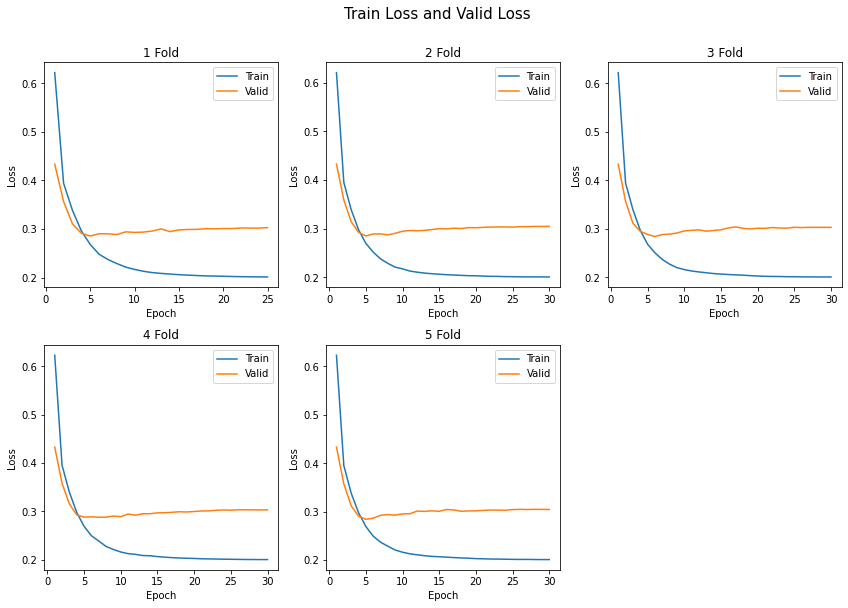

In [45]:
show_loss_plot(acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch)

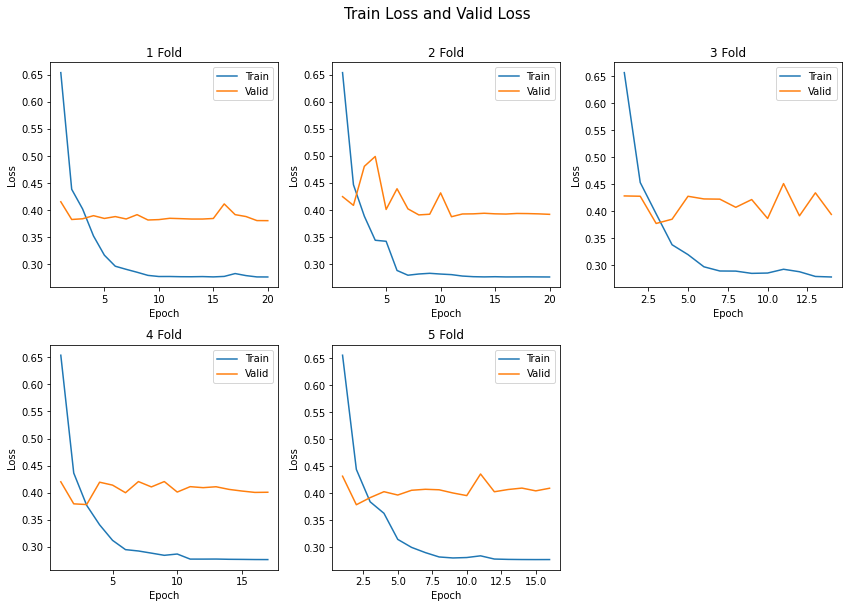

In [46]:
show_loss_plot(asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch)

## Test 예측

In [47]:
def acd_predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        device: torch.device,
        return_prob: bool = False
    ) -> Tensor:
    """test text를 보고 개체 속성을 분류"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = torch.zeros(len(dataloader.dataset), NUM_CLASSES['ACD'])  

    for weight_path in tqdm(weight_path_list):
        clear_gpu()
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        with torch.no_grad(): 
            for batch in dataloader:  ## test 데이터는 라벨(y)이 없다
                args = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
                with torch.cuda.amp.autocast():
                    y_hat = F.sigmoid(model(*args)[0]).detach().cpu().numpy()
                    y_hat = np.apply_along_axis(max_to_1, 1, y_hat)   ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])
                del args, y_hat  

        test_probs += (torch.from_numpy(probs) / NUM_FOLDS)  ## 각 컬럼별 확률
    test_preds = torch.where(test_probs >= 0.5, 1, 0)  ## threshold(0.5)보다 크면 positive 그렇지 않으면 negative
    
    ## save gpu memory
    model.cpu()
    del model
    
    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [48]:
def asc_predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        device: torch.device,
        return_prob: bool = False
    ) -> Tensor:
    """개체 속성을 분류한 후 존재하는 개체 속성에 대해 감성 분류"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt') 
    test_probs = torch.zeros(len(dataloader.dataset), NUM_CLASSES['ASC'])  

    for weight_path in tqdm(weight_path_list):
        clear_gpu()
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        with torch.no_grad(): 
            for batch in dataloader:  ## test 데이터는 라벨(y)이 없다
                args = [*(map(lambda tensor: tensor.to(device), batch['ASC']))]
                with torch.cuda.amp.autocast():
                    y_hat = model(*args)[0].detach().cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])
                del args, y_hat  

        test_probs += (torch.softmax(torch.from_numpy(probs), dim=-1) / NUM_FOLDS)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=-1)  ## 최댓값과 인덱스
    
    ## save gpu memory
    model.cpu()
    del model
    
    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [ ]:
def fill_annotation(jsonl: List[JsonType], df: pd.DataFrame) -> List[JsonType]:
    """
    test jsonl의 annotation을 df의 entity_property와 sentiment로 채운다 (In-Place)
    For submission 
    """
    list_df = df.to_numpy().tolist()
    for idx, json in enumerate(jsonl):
        assert json['id'].split('-')[-1] == list_df[idx][0]  ## id는 동일해야 함
        jsonl[idx]['annotation'] = list(map(list, zip(list_df[idx][2], list_df[idx][3])))
        
    return jsonl

In [49]:
test_acd_dataloader = DataLoader(ACDDataset(test, tokenizer, MAX_LEN), batch_size=1024)

In [51]:
acd_preds = acd_predict(acd_model, test_acd_dataloader, SAVE_PATHS['ACD'], device=DEVICE)

In [ ]:
acd_preds = acd_predict(acd_model, test_acd_dataloader, SAVE_PATHS['ACD'], device=DEVICE)
test['entity_property'] = list(map(list, ACD_ENCODER.inverse_transform(acd_preds)))
test = to_tidy(test, exist_sentiment=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
test_absa_dataloader = DataLoader(ABSADataset(test, tokenizer, MAX_LEN), batch_size=1024)

In [ ]:
asc_preds = asc_predict(asc_model, test_absa_dataloader, SAVE_PATHS['ASC'], device=DEVICE)
test['sentiment'] =  ASC_ENCODER.inverse_transform(asc_preds)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
test = to_untidy(test)

In [ ]:
test_jsonl = fill_annotation(load_jsonl(test_path) , test)

In [ ]:
write_jsonl(test_jsonl, submission_path)